In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
        
# IMAGE_SIZE = 224 #EfficientNetB0, DenseNet121
IMAGE_SIZE = 448 # EfficientNetV2M

In [2]:
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
# from sklearn.model_selection import train_test_split
# from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [3]:
datasets=['./offline-train.pkl','./train_caption.txt']
valid_datasets=['./offline-test.pkl', './test_caption.txt']
dictionaries=['./dictionary.txt']
batch_Imagesize=500000
valid_batch_Imagesize=500000
# batch_size for training and testing
batch_size=32
# the max (label length/Image size) in training and testing
# you can change 'maxlen','maxImagesize' by the size of your GPU
maxlen=48
maxImagesize= 100000
# hidden_size in RNN
hidden_size = 256
# teacher_forcing_ratio 
teacher_forcing_ratio = 1

AUG = False
AUG_NUM = 5

Data Augmentation

In [4]:
# import albumentations as A
from tqdm import tqdm
import cv2

Construct dictionaries

In [5]:
fp=open(dictionaries[0])

symbol_index={}

for line in fp.readlines():
    words = line.strip().split()
    symbol_index[words[0]]=int(words[1])  # word->index

fp.close()

print('total words/phones',len(symbol_index))

index_symbol={}
for k,v in symbol_index.items():
    index_symbol[v]=k  # index->word
    
print('total words/phones',len(index_symbol))


total words/phones 112
total words/phones 112


In [6]:
label_fp = open(datasets[1], 'r')
labels = label_fp.readlines()
label_fp.close()
label_num = len(labels)
print('total labels',label_num)

caption_list = []

for i in range(label_num):

    label = labels[i].strip().split()
    file_id = label[0]
    label = label[1:]
    caption_list.append(label)
        
# caption_list = np.array(caption_list)
print('caption_list[0]',caption_list[0])

total labels 8835
caption_list[0] ['f', '(', 'x', ')', '=', '\\sum', '_', '{', 'n', '=', '-', '\\infty', '}', '^', '{', '\\infty', '}', 'a', '_', '{', 'n', '}', '=', 'x', '^', '{', '\\alpha', '_', '{', 'n', '}', '}']


In [7]:
img_name_list = []
# caption_list = []
i = 0
with open('./train_caption.txt') as fh:
    for line in fh:
        image_name = line.strip().split()[0]
        caption = caption_list[i]
        img_name_list.append(f'./off_image_train/{image_name}_0.jpg')
        caption_list[i] = ('<start> ' + ' '.join(caption) + ' <end>')
        i += 1
        
# Only first 120,000 images have labels

# test_img_name = set(glob(f'./words_captcha/*.png')) - set(img_name_list)
# img_name_list += sorted(test_img_name)

print(img_name_list[0])
print(caption_list[0]) 

./off_image_train/formulaire004-equation047_0.jpg
<start> f ( x ) = \sum _ { n = - \infty } ^ { \infty } a _ { n } = x ^ { \alpha _ { n } } <end>


In [8]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='', filters=' ')
# tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='')
tokenizer.fit_on_texts(caption_list)
caption_seq = tokenizer.texts_to_sequences(caption_list)

# iterate over the whole dataset if its caption over 48 words, remove it

tmp_image_name_list = []
tmp_caption_seq = []

for i in range(len(caption_seq)):
    if len(caption_seq[i]) <= 48:
        tmp_image_name_list.append(img_name_list[i])
        tmp_caption_seq.append(caption_seq[i])

img_name_list = tmp_image_name_list
caption_seq = tmp_caption_seq

caption_seq = tf.keras.preprocessing.sequence.pad_sequences(caption_seq, padding='post')
max_length = len(caption_seq[0])

print(caption_list[0])
print(caption_seq[0])
print (max_length)

<start> f ( x ) = \sum _ { n = - \infty } ^ { \infty } a _ { n } = x ^ { \alpha _ { n } } <end>
[ 4 30 13 10 14 16 39 11  2 19 16 12 53  3  8  2 53  3 17 11  2 19  3 16
 10  8  2 52 11  2 19  3  3  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
48


In [9]:
img_name_train = img_name_list[:6500]
img_name_valid = img_name_list[6500:]

caption_seq_train = caption_seq[:6500]
caption_seq_valid = caption_seq[6500:]

# img_name_test = img_name_list[120000:]
# caption_seq_test = caption_seq[120000:]

# print the first caption and image name
print('caption_seq_train[0]',caption_seq_train[0])
print('img_name_train[0]',img_name_train[0])


caption_seq_train[0] [ 4 30 13 10 14 16 39 11  2 19 16 12 53  3  8  2 53  3 17 11  2 19  3 16
 10  8  2 52 11  2 19  3  3  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
img_name_train[0] ./off_image_train/formulaire004-equation047_0.jpg


In [10]:
import os
for i in range(len(img_name_train)):
    if not os.path.exists(img_name_train[i]):
        print('not exist',img_name_train[i])
        break

not exist ./off_image_train/formulaire004-equation047_0.jpg


In [11]:
BATCH_SIZE = 16 # 100 is a suck number
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE

In [12]:
def load_image(image_path, caption):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    # Let's try to use padding instead of resize
    img = tf.image.resize_with_pad(img, IMAGE_SIZE, IMAGE_SIZE)
    
    # plt.imshow(img)
    # plt.show()
    
    # image = tf.keras.applications.densenet.preprocess_input(img)
    # image = tf.keras.applications.efficientnet.preprocess_input(img)
    image = tf.keras.applications.efficientnet_v2.preprocess_input(img)
    return image, caption

In [13]:
dataset_train = tf.data.Dataset.from_tensor_slices((img_name_train, caption_seq_train))\
                               .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                               .shuffle(BUFFER_SIZE)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .prefetch(tf.data.experimental.AUTOTUNE)

dataset_valid = tf.data.Dataset.from_tensor_slices((img_name_valid, caption_seq_valid))\
                               .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
image_model = tf.keras.applications.EfficientNetV2M(include_top=False,
                                                weights='imagenet')
# image_model = tf.keras.applications.DenseNet121(include_top=False,
#                                                 weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

feature_extractor = tf.keras.Model(new_input, hidden_layer)

In [15]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [16]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [17]:
# class RNN_Decoder(tf.keras.Model):
#     def __init__(self, embedding_dim, units, vocab_size):
#         super(RNN_Decoder, self).__init__()
#         self.units = units

#         self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#         self.lstm = tf.keras.layers.LSTM(self.units,
#                                          return_sequences=True,
#                                          return_state=True,
#                                          recurrent_initializer='glorot_uniform')
#         self.fc1 = tf.keras.layers.Dense(self.units)
#         self.fc2 = tf.keras.layers.Dense(vocab_size)

#         self.attention = BahdanauAttention(self.units)

#     def call(self, x, features, hidden):
#         # defining attention as a separate model
#         context_vector, attention_weights = self.attention(features, hidden[0])

#         # x shape after passing through embedding == (batch_size, 1, embedding_dim)
#         x = self.embedding(x)

#         # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
#         x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

#         # passing the concatenated vector to the LSTM
#         output, state_h, state_c = self.lstm(x, initial_state=hidden)

#         # shape == (batch_size, max_length, hidden_size)
#         x = self.fc1(output)

#         # x shape == (batch_size * max_length, hidden_size)
#         x = tf.reshape(x, (-1, x.shape[2]))

#         # output shape == (batch_size * max_length, vocab)
#         x = self.fc2(x)

#         return x, [state_h, state_c], attention_weights

#     def reset_state(self, batch_size):
#         return [tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units))]

In [18]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru1 = tf.keras.layers.GRU(self.units,
                                        return_sequences=True,
                                        return_state=True,
                                        recurrent_initializer='glorot_uniform')
        self.gru2 = tf.keras.layers.GRU(self.units,
                                        return_sequences=True,
                                        return_state=True,
                                        recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.dropout = tf.keras.layers.Dropout(0.1)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden[0])

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the first GRU
        output, state = self.gru1(x, initial_state=hidden)

        # passing the output of the first GRU to the second GRU
        output, state = self.gru2(output, initial_state=state)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # applying dropout
        x = self.dropout(x)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, [state], attention_weights

    def reset_state(self, batch_size):
        return [tf.zeros((batch_size, self.units))]

In [19]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [21]:
checkpoint_path = r"C:\Users\a2004\Downloads\ML_portable\checkpoints\train"
ckpt = tf.train.Checkpoint(feature_extractor=feature_extractor,
                           encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

In [22]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

ckpt_manager.restore_or_initialize()

'C:\\Users\\a2004\\Downloads\\ML_portable\\checkpoints\\train\\ckpt-49'

In [23]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []
valid_plot = []

In [24]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    # tf.compat.v1.enable_eager_execution()
    
    # plt.imshow(img_tensor[0].numpy())
    # plt.show()

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    batch_size = img_tensor.shape[0]
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)
    hidden = decoder.reset_state(batch_size=batch_size)

    with tf.GradientTape() as tape:
        #  Instead of prestore the features into npy file, we called the feature_extractor directly (Easier to implement lol)
        features = feature_extractor(img_tensor, True)
        features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
        features = encoder(features)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [25]:
from tqdm import tqdm

In [26]:
def predict(img_tensor):
    batch_size = img_tensor.shape[0]
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)

    hidden = decoder.reset_state(batch_size=batch_size)
    
    features = feature_extractor(img_tensor)
    features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
    features = encoder(features)


    result = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)
    
    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        
        predicted_id = tf.argmax(predictions, axis=1).numpy()
        dec_input = tf.expand_dims(predicted_id, 1)
        result = tf.concat([result, predicted_id.reshape((batch_size, 1))], axis=1)

    return result

In [27]:
def build_output(args):
    results = []
    for i in args:
        result = ""
        for s in i[1:]:
            if s == tokenizer.word_index["<end>"]:
                break
            else :
                result += (tokenizer.index_word[s] + " ")
        results.append(result)
    return results

In [28]:
def evaluate(dataset_valid):
    total = 0
    correct = 0
    for img_tensor, target in dataset_valid:
        
        pred_list = build_output(predict(img_tensor).numpy())
        real_list = build_output(target.numpy())
        
        total += min(len(pred_list), len(real_list))
        correct += sum([1 for pred, real in zip(pred_list, real_list) if pred == real]) 
        
        # if(pred_list == real_list):
        #     correct += 1
        # total += 1

    return correct / total

In [29]:
EPOCHS = 200
EPOCHS = 0
start = time.time()

max_accuracy = 0.0

for epoch in range(start_epoch, EPOCHS):
    
    total_loss = 0

    for (batch, (img_tensor, target)) in tqdm(enumerate(dataset_train), total=num_steps):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

    loss_plot.append(total_loss / num_steps)
    
    accuracy = evaluate(dataset_valid)
    valid_plot.append(accuracy)
    
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f} Valid {:.3f} History Valid {:.3f}'.format(epoch + 1,
                                         total_loss/num_steps, accuracy, max_accuracy))
    
    if(accuracy >= 0.90):
        break
    
print ('Time taken for {} epoch {} sec\n'.format(EPOCHS, time.time() - start))
'''
'''

Time taken for 0 epoch 0.0 sec



'\n'

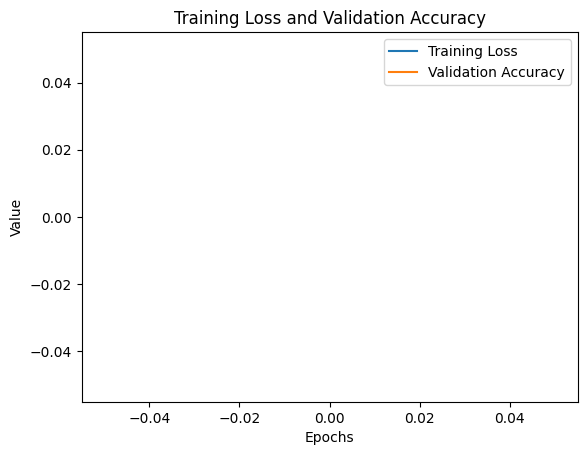

In [30]:
plt.plot(loss_plot, label='Training Loss')
plt.plot(valid_plot, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Validation Accuracy')
plt.legend()
plt.show()

#### Validation

#### Predictions over test set

In [31]:
# ckpt = tf.train.Checkpoint(feature_extractor=feature_extractor,
#                            encoder=encoder,
#                            decoder=decoder,
#                            optimizer=optimizer)

In [32]:
# ckpt.restore('./checkpoints/train/ckpt-33')

In [34]:
# score = evaluate(dataset_valid)
# print(f'Final Validation Accuracy: {score:.3f}')

In [35]:
def map_test(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    # img = tf.keras.applications.inception_v3.preprocess_input(img)
    image = tf.keras.applications.efficientnet_v2.preprocess_input(img)
    return image, image_path

In [36]:
img_name_test = ["./2+4.jpg"]

In [37]:
dataset_test = tf.data.Dataset.from_tensor_slices((img_name_test))\
                              .map(map_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                              .batch(BATCH_SIZE)\
                              .prefetch(tf.data.experimental.AUTOTUNE)

output text prediction

In [38]:
from IPython.display import Latex

ans = []

with open('./output.txt', 'w') as fh:
    for img_tensor, img_path in tqdm(dataset_test):
        pred_list = build_output(predict(img_tensor).numpy())
        for path, pred in zip(img_path, pred_list):
            # img_name = re.search(r'(\w+)\._0.jpg', path.numpy().decode()).group(1)
            img_name = path
            fh.write(f'{img_name} {pred}\n')
            print(f'{img_name}\n {pred}')
            ans.append(pred)
            
# Latex("$" + r"\frac{a}{\sin x}+\frac{p}{b^{x}}" + "$")
print("Predictions:")
Latex("$" + pred + "$")

100%|██████████| 1/1 [00:02<00:00,  2.65s/it]

b'./2+4.jpg'
 \int \sin \beta d x 
Predictions:


<IPython.core.display.Latex object>

In [39]:
from IPython.display import Latex

# Latex("$" + r"\frac{a}{\sin9}=\frac{b}{\sin4}" + "$")

Draw Attention gif

In [40]:
image_features_extract_model = tf.keras.applications.EfficientNetV2M(include_top=False,
                                                weights='imagenet')
attention_features_shape = 196

def evaluate_1(img_path):
    
    batch_size = 1
    
    attention_plot = np.zeros((max_length, attention_features_shape))
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)

    hidden = decoder.reset_state(batch_size=batch_size)
    
    features = feature_extractor(img_tensor)
    features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
    features = encoder(features)


    result = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)
    
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        predicted_id = tf.argmax(predictions, axis=1).numpy()
        dec_input = tf.expand_dims(predicted_id, 1)
        result = tf.concat([result, predicted_id.reshape((batch_size, 1))], axis=1)
        
    attention_plot = attention_plot[:len(result[0]), :]

    return result, attention_plot

In [41]:
result, attention_plot = evaluate_1(img_name_test[0])

# print('Prediction Caption:', (result[0]))

# transform sysbol to latex

result = result[0].numpy()
string = []

print('Prediction Caption:', (result))

for i in range(len(result)):
    if result[i] == tokenizer.word_index['<end>']:
        string.append(tokenizer.index_word[result[i]])
        break
    # print(tokenizer.index_word[result[i]], end=' ')
    string.append(tokenizer.index_word[result[i]])

string = string[1:-1]
print('Prediction Caption:', string)

Prediction Caption: [ 4 43 33 63 27 10  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5]
Prediction Caption: ['\\int', '\\sin', '\\beta', 'd', 'x']


In [42]:
import imageio

# def plot_attention(image, result, attention_plot):
#     temp_image = np.array(Image.open(image))

#     fig = plt.figure(figsize=(100, 100))

#     len_result = len(result)
#     for l in range(len_result):
#         temp_att = np.resize(attention_plot[l], (10, 10))
#         ax = fig.add_subplot(len_result//2, len_result//2, l+1)
#         ax.set_title(result[l])
#         img = ax.imshow(temp_image)
#         ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

#     plt.tight_layout()
#     plt.show()
    
# plt.imshow(np.array(Image.open(img_name_test[0])))

# plot_attention(img_name_test[0], string, attention_plot)

def generate_gif(image_path, result, attention_plot, gif_path='attention.gif'):
    temp_image = np.array(Image.open(image_path))
    frames = []

    len_result = len(result)
    for l in range(len_result):
        fig, ax = plt.subplots(figsize=(10, 10))
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
        plt.axis('off')

        # Save the current frame
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        plt.close(fig)

    # Save frames as a gif
    imageio.mimsave(gif_path, frames, fps=5)

generate_gif(img_name_test[0], string, attention_plot)
# display the gif
from IPython.display import Image
Image(filename='attention.gif')


ModuleNotFoundError: No module named 'imageio'